> ## Import Libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd


# custom modules
import sys
sys.path.append('../')
from scripts.dataframe import load_data as ld;
from scripts.plots import *
from scripts.modeling import *

/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> ## Load Dataset

In [2]:
data_paths = {
    'train' : '../docs/train_data.txt',
    'test':'../docs/test_data.txt',
    'test_solution':'../docs/test_data_solution.txt'
}
train_data = ld(data_paths['train'])
test_data = ld(data_paths['test'])
test_data_solution = ld(data_paths['test_solution'])
train_data.head()

,id,title,genre,plot
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [3]:
test_data.head()

,id,title,plot
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...


In [6]:
# import pandas as pd
# train_data = pd.read_csv(data_paths['train'],sep=':::', names=["id", "title","genre","plot"])
# train_data.head()

> ## EDA

In [4]:
train_data.describe()

,id,title,genre,plot
count,54214,54214,54214,54214
unique,54214,54214,27,54086
top,54214,Nature's Fury: Storm of the Century (2006),drama,Grammy - music award of the American academy o...
freq,1,1,13613,12


>> ### Check for null values

In [5]:
for col in train_data.columns:
    if (len(train_data)==train_data[col].notna().sum()):
        print(f"No null values in {col} column")
    else:
        print(f"Found {len(train_data) - train_data[col].notna().sum()} null values in {col}")

No null values in id column
No null values in title column
No null values in genre column
No null values in plot column


>> ### Genre Distribution plot

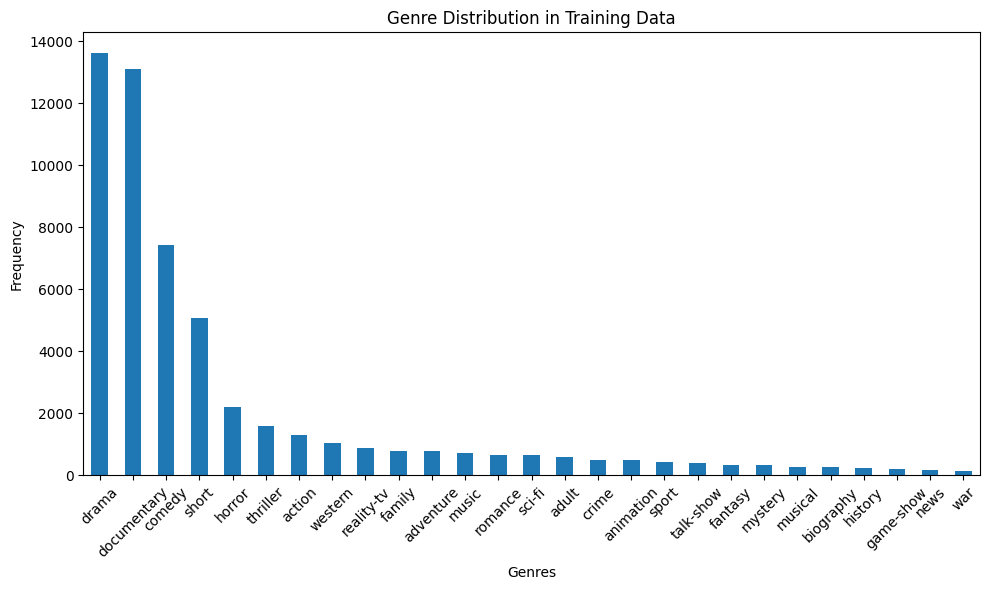

In [6]:
genre_distibution(train_data)

>> ### Movie-Plot Distribution plot

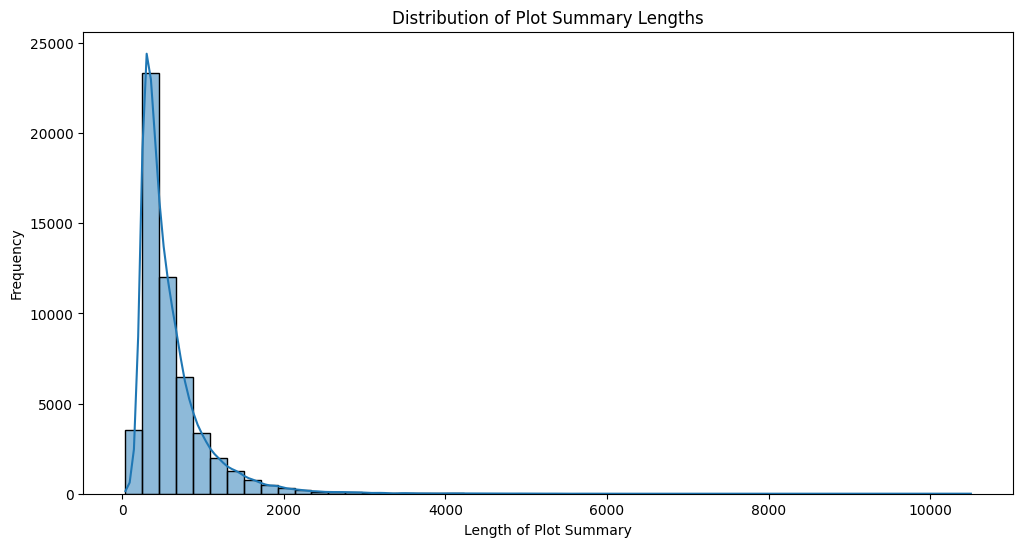

In [7]:
movie_plot_distribution(train_data)

>> ### Top Genres plot

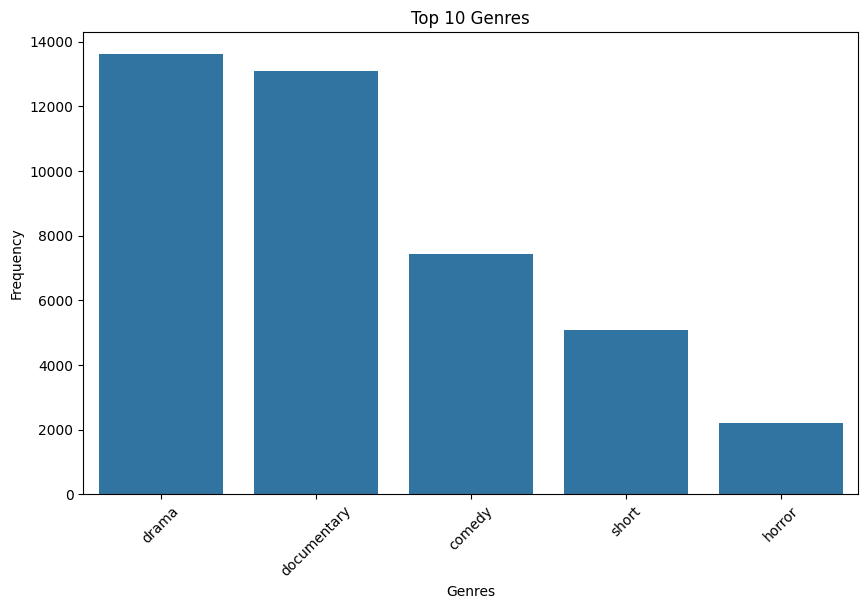

In [8]:
top_5_genres(train_data)

>> ### TF_IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer(max_features=10000)

X_train_tfidf = vector.fit_transform(train_data['plot'])
X_test_tfidf = vector.fit_transform(test_data['plot'])

>> ## Encode target labels

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['genre'])
y_test = label_encoder.fit_transform(test_data_solution['genre'])
print(label_encoder.classes_)

['action' 'adult' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'game-show' 'history' 'horror'
 'music' 'musical' 'mystery' 'news' 'reality-tv' 'romance' 'sci-fi'
 'short' 'sport' 'talk-show' 'thriller' 'war' 'western']


>> ## Modeling - Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf,y_train)

y_pred = lr_model.predict(X_test_tfidf)
predicted_genres = label_encoder.inverse_transform(y_pred)

test_data['predicted_genre'] = predicted_genres
test_data[['title','predicted_genre']].head()

,title,predicted_genre
0,Edgar's Lunch (1998),drama
1,La guerra de papá (1977),documentary
2,Off the Beaten Track (2010),documentary
3,Meu Amigo Hindu (2015),drama
4,Er nu zhai (1955),comedy


In [ ]:
merge_data = pd.merge(test_data_solution[['id','genre']], test_data[['id','predicted_genre']], on='id')
merge_data.head()

,id,genre,predicted_genre
0,1,thriller,drama
1,2,comedy,documentary
2,3,documentary,documentary
3,4,drama,drama
4,5,drama,comedy


In [13]:
accuracy = accuracy_score(merge_data['genre'],merge_data['predicted_genre'])
print(f"accuracy : {accuracy}")

print("classification report:\n", classification_report(merge_data['genre'],merge_data['predicted_genre']))

accuracy : 0.26690036900369


/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classification report:
               precision    recall  f1-score   support

      action       0.24      0.00      0.01      1314
       adult       0.00      0.00      0.00       590
   adventure       0.00      0.00      0.00       775
   animation       0.00      0.00      0.00       498
   biography       0.00      0.00      0.00       264
      comedy       0.26      0.32      0.29      7446
       crime       0.00      0.00      0.00       505
 documentary       0.34      0.56      0.43     13096
       drama       0.34      0.20      0.25     13612
      family       0.00      0.00      0.00       783
     fantasy       0.00      0.00      0.00       322
   game-show       0.00      0.00      0.00       193
     history       0.00      0.00      0.00       243
      horror       0.35      0.01      0.03      2204
       music       0.00      0.00      0.00       731
     musical       0.00      0.00      0.00       276
     mystery       0.00      0.00      0.00       318
   

/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>> ## NaiveB

In [14]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf,y_train)

MultinomialNB()

In [15]:
y_pred_nb = nb_model.predict(X_test_tfidf)
predicted_genres_nb = label_encoder.inverse_transform(y_pred_nb)
test_data['predicted_genre_nb'] = predicted_genres_nb
merge_data_nb = pd.merge(test_data_solution,test_data[['id','predicted_genre_nb']],on='id')

In [17]:
accuracy = accuracy_score(merge_data_nb['genre'],merge_data_nb['predicted_genre_nb'])
print(f"accuracy : {accuracy}")

print("classification report:\n", classification_report(merge_data_nb['genre'],merge_data_nb['predicted_genre_nb']))

accuracy : 0.1820110701107011


/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classification report:
               precision    recall  f1-score   support

      action       0.05      0.11      0.07      1314
       adult       0.04      0.04      0.04       590
   adventure       0.02      0.05      0.03       775
   animation       0.01      0.01      0.01       498
   biography       0.00      0.00      0.00       264
      comedy       0.26      0.18      0.21      7446
       crime       0.04      0.02      0.03       505
 documentary       0.34      0.41      0.37     13096
       drama       0.33      0.10      0.16     13612
      family       0.02      0.06      0.03       783
     fantasy       0.00      0.00      0.00       322
   game-show       1.00      0.01      0.01       193
     history       0.00      0.00      0.00       243
      horror       0.17      0.09      0.11      2204
       music       0.03      0.14      0.05       731
     musical       0.00      0.00      0.00       276
     mystery       0.00      0.00      0.00       318
   

/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/am/PycharmProjects/CODSOFT/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>> ## SVM model

In [5]:
# X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train_tfidf, y_train)

y_test_pred = clf.predict(X_test_tfidf)
print("Validation Accuracy:", accuracy_score(y_test, y_test_pred))
print("Validation Classification Report: \n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.26309963099630995
Validation Classification Report: 
               precision    recall  f1-score   support

           0       0.05      0.03      0.04      1314
           1       0.07      0.02      0.03       590
           2       0.03      0.01      0.02       775
           3       0.00      0.00      0.00       498
           4       0.00      0.00      0.00       264
           5       0.23      0.29      0.26      7446
           6       0.00      0.00      0.00       505
           7       0.34      0.58      0.43     13096
           8       0.30      0.25      0.27     13612
           9       0.03      0.01      0.01       783
          10       0.20      0.00      0.01       322
          11       0.02      0.01      0.01       193
          12       0.00      0.00      0.00       243
          13       0.16      0.04      0.06      2204
          14       0.03      0.02      0.03       731
          15       0.03      0.00      0.01       276
    

>> ## Preprocess the plot column

In [7]:
train_data['cleaned_plot'] = train_data['plot'].apply(preprocess_text)

print(train_data[['plot', 'cleaned_plot']].head())

                                                plot  \
0  Listening in to a conversation between his doc...   
1  A brother and sister with a past incestuous re...   
2  As the bus empties the students for their fiel...   
3  To help their unemployed father make ends meet...   
4  The film's title refers not only to the un-rec...   

                                        cleaned_plot  
0  listening conversation doctor parent yearold o...  
1  brother sister past incestuous relationship cu...  
2  bus empty student field trip museum natural hi...  
3  help unemployed father make end meet edith twi...  
4  film title refers unrecovered body ground zero...  


> ## Models saved Using Google Colab

In [ ]:
train_data['bert_embeddings'] = train_data['cleaned_plot'].apply(get_bert_embeddings)
X = np.vstack(train_data['bert_embeddings'])
y = train_data['genre']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # SMOTE already balances the dataset
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['genre'])


In [ ]:
joblib.dump(xgb_model, 'xgb_genre_classifier.pkl')

print("Model and LabelEncoder saved as .pkl files.")

! The above code is run only on colab no output here

In [14]:
xgb_model = joblib.load('../models/xgb_genre_classifier.pkl')

>> ### Model Performance 

In [ ]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/am/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /home/am/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/am/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/am/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/am/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /home/am/nltk_data...


True

In [ ]:
print(word_tokenize("Hello, world! This is a test."))

['Hello', ',', 'world', '!', 'This', 'is', 'a', 'test', '.']


In [ ]:
doc_example = "The Inuit people live in an igloo, it is freezing out here."
predicted_genre_loaded = predict_genre_from_saved_model(doc_example, xgb_model,label_encoder)
print("Predicted Genre using saved model:", predicted_genre_loaded)


Predicted Genre using saved model: documentary
